# Heart-Failure-Identifier
----------------------------------------------------------------------------------------------------------------------
**CSCI 4050U, Machine Learning** <br>
Professor Ken Pu. <br>
Course Final Project <br>
Faculty of Science, Ontario Tech University <br>
April 16, 2023 <br>

**Our Team.** <br>
Rija Baig (100746674) <br>
Preet Panchal (100707094) <br>
Eihab Syed (100707448) <br>

**Link to the Dataset.** <br>
https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

**About the Dataset.** <br>
The dataset is a combined heart disease dataset consisting of 11 features and 918 observations. The aim of the dataset is to predict the presence of heart disease in patients using these features. The features in the dataset include age, sex, chest pain type, resting blood pressure, serum cholesterol, fasting blood sugar, resting electrocardiogram results, maximum heart rate achieved, exercise-induced angina, oldpeak, and the slope of the peak exercise ST segment. The dataset was created by combining five different heart disease datasets, making it the largest heart disease dataset available for research purposes.

**Problem.** <br> 
For our project, we are studying a binary classification problem, where we try to predict whether a patient has heart disease or not based on the 11 input features. The problem can be framed as training a machine learning model to accurately classify patients into two categories: those with heart disease (output class = 1) and those without heart disease (output class = 0). 

**Objective.** <br>
The aim of the project would be to develop a machine learning model that can generalize well on unseen data and achieve a high accuracy rate on the test set.

In [108]:
# Import libraries
import time
import torch
from torch import nn
from torch import optim
from torch import tensor
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
import torchvision
from torchsummaryX import summary
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
from importlib import reload

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from sklearn.metrics import confusion_matrix,classification_report,f1_score

import warnings
warnings.filterwarnings('ignore')

## Loading the Data

In [109]:
# Loading the dataset
df = pd.read_csv('data/heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [110]:
df.shape

(918, 12)

In [111]:
# Loading the target values (ie. the output class)
target = df.iloc[:, 11]
target.head()

0    0
1    1
2    0
3    1
4    0
Name: HeartDisease, dtype: int64

In [112]:
# Loading the dataset with the 11 features
features = df.iloc[:, :-1]
features.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up


In [113]:
# Getting information of our 11 attributes
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
dtypes: float64(1), int64(5), object(5)
memory usage: 79.0+ KB


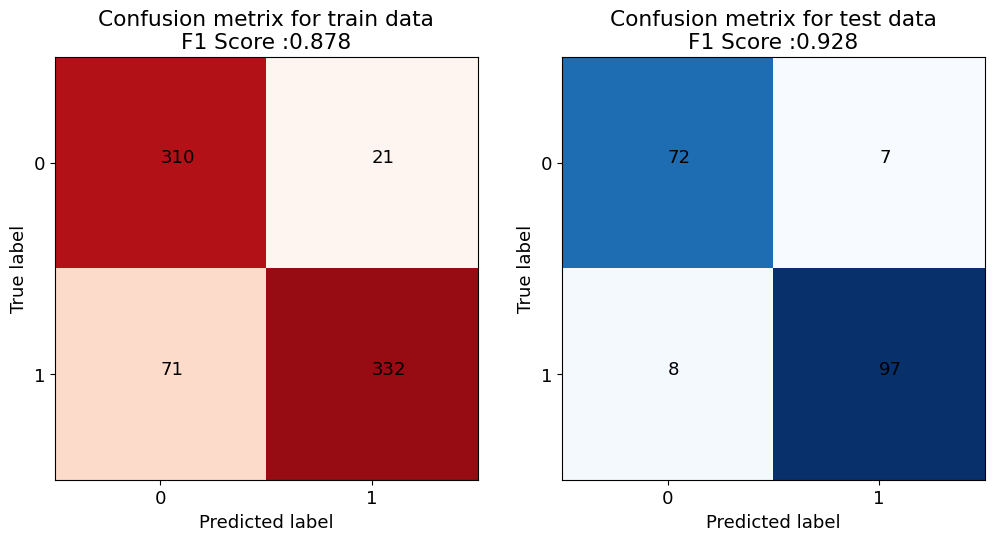

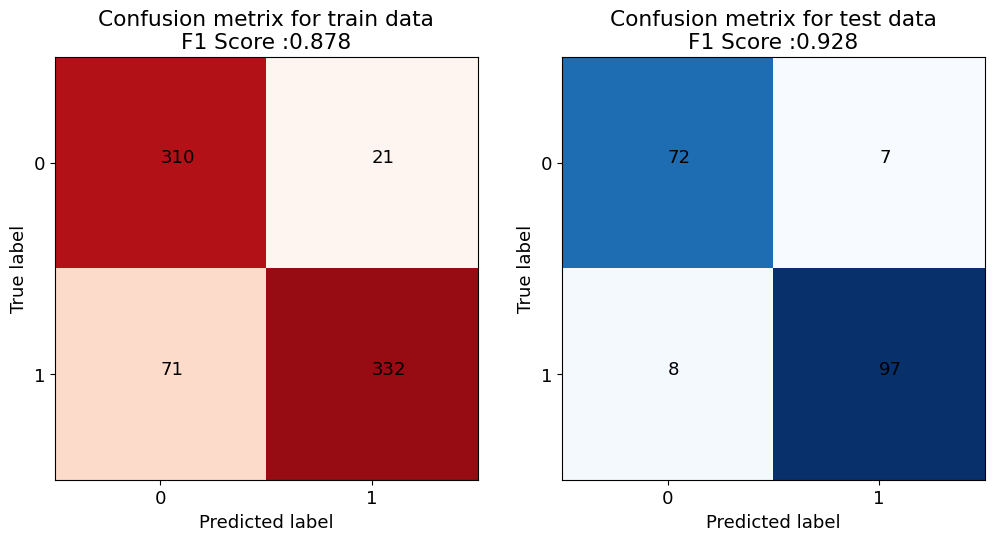

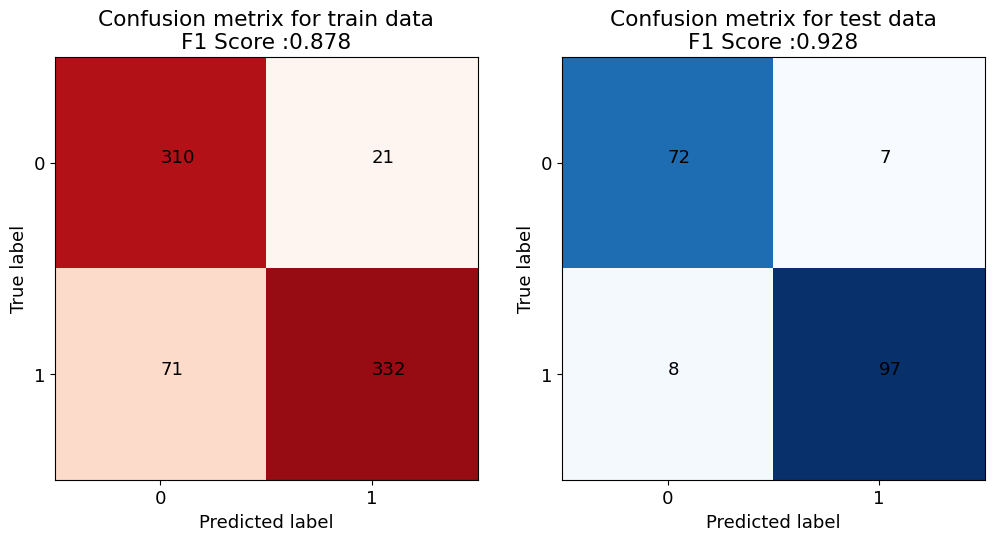

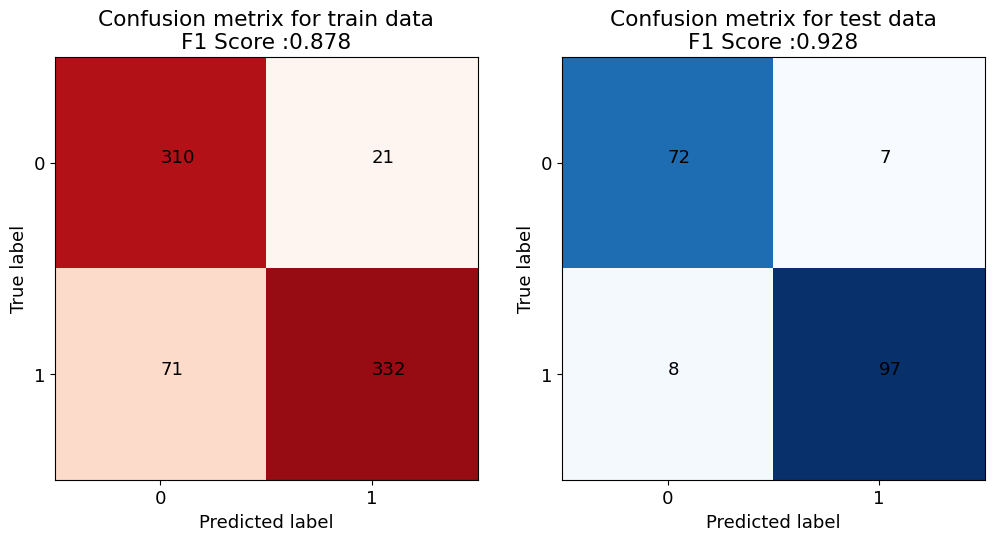

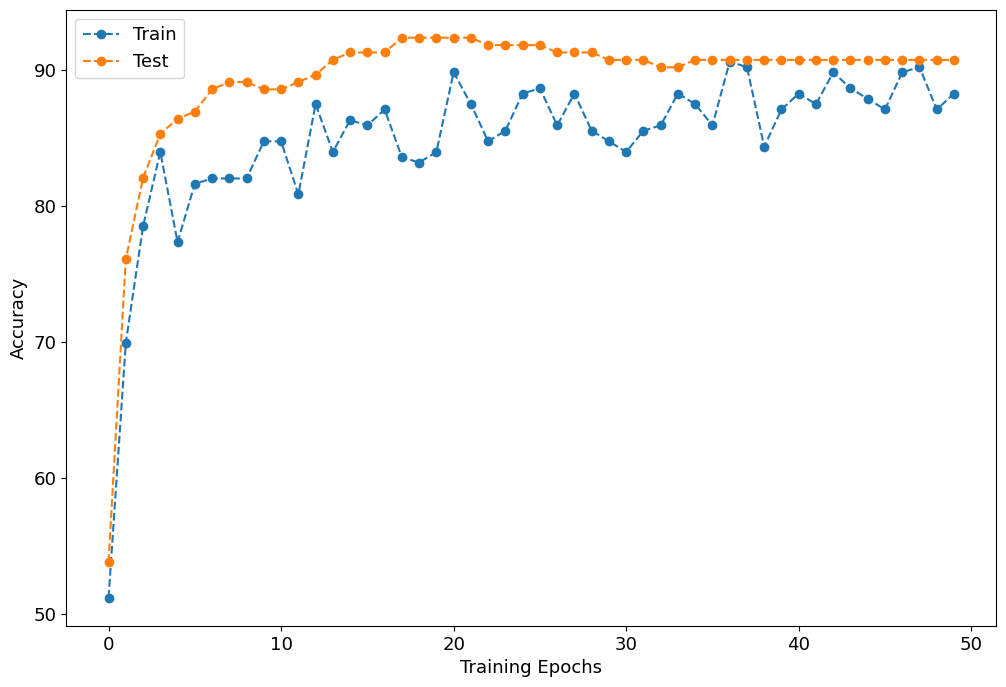

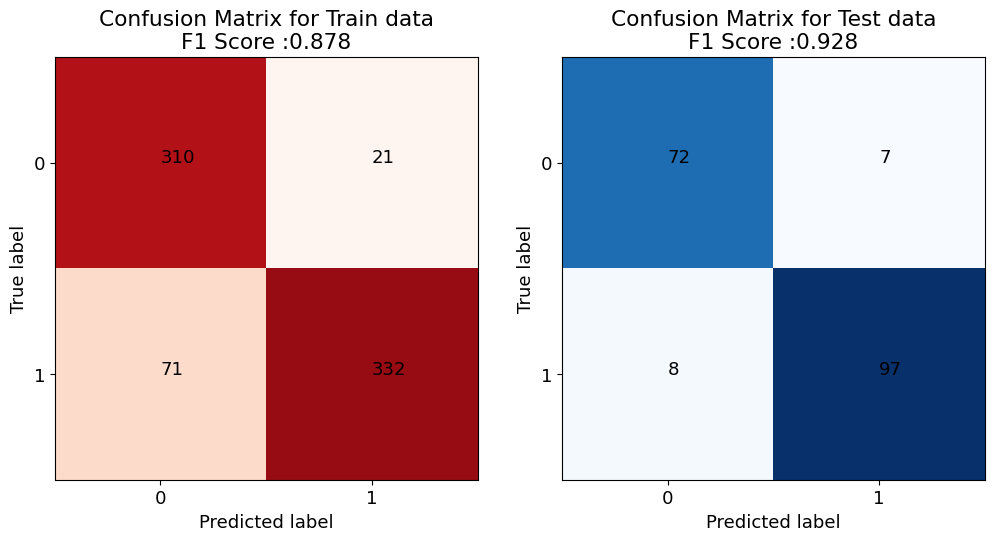

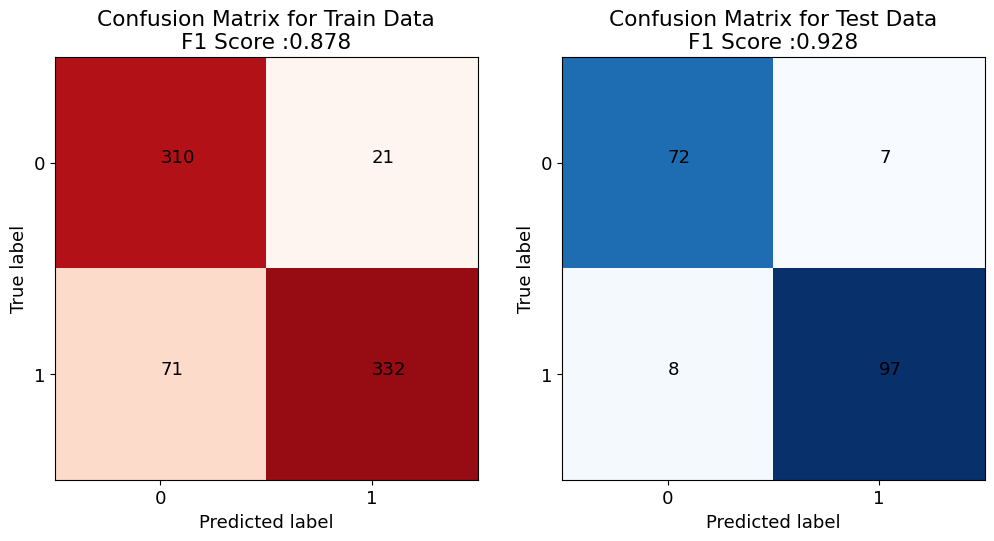

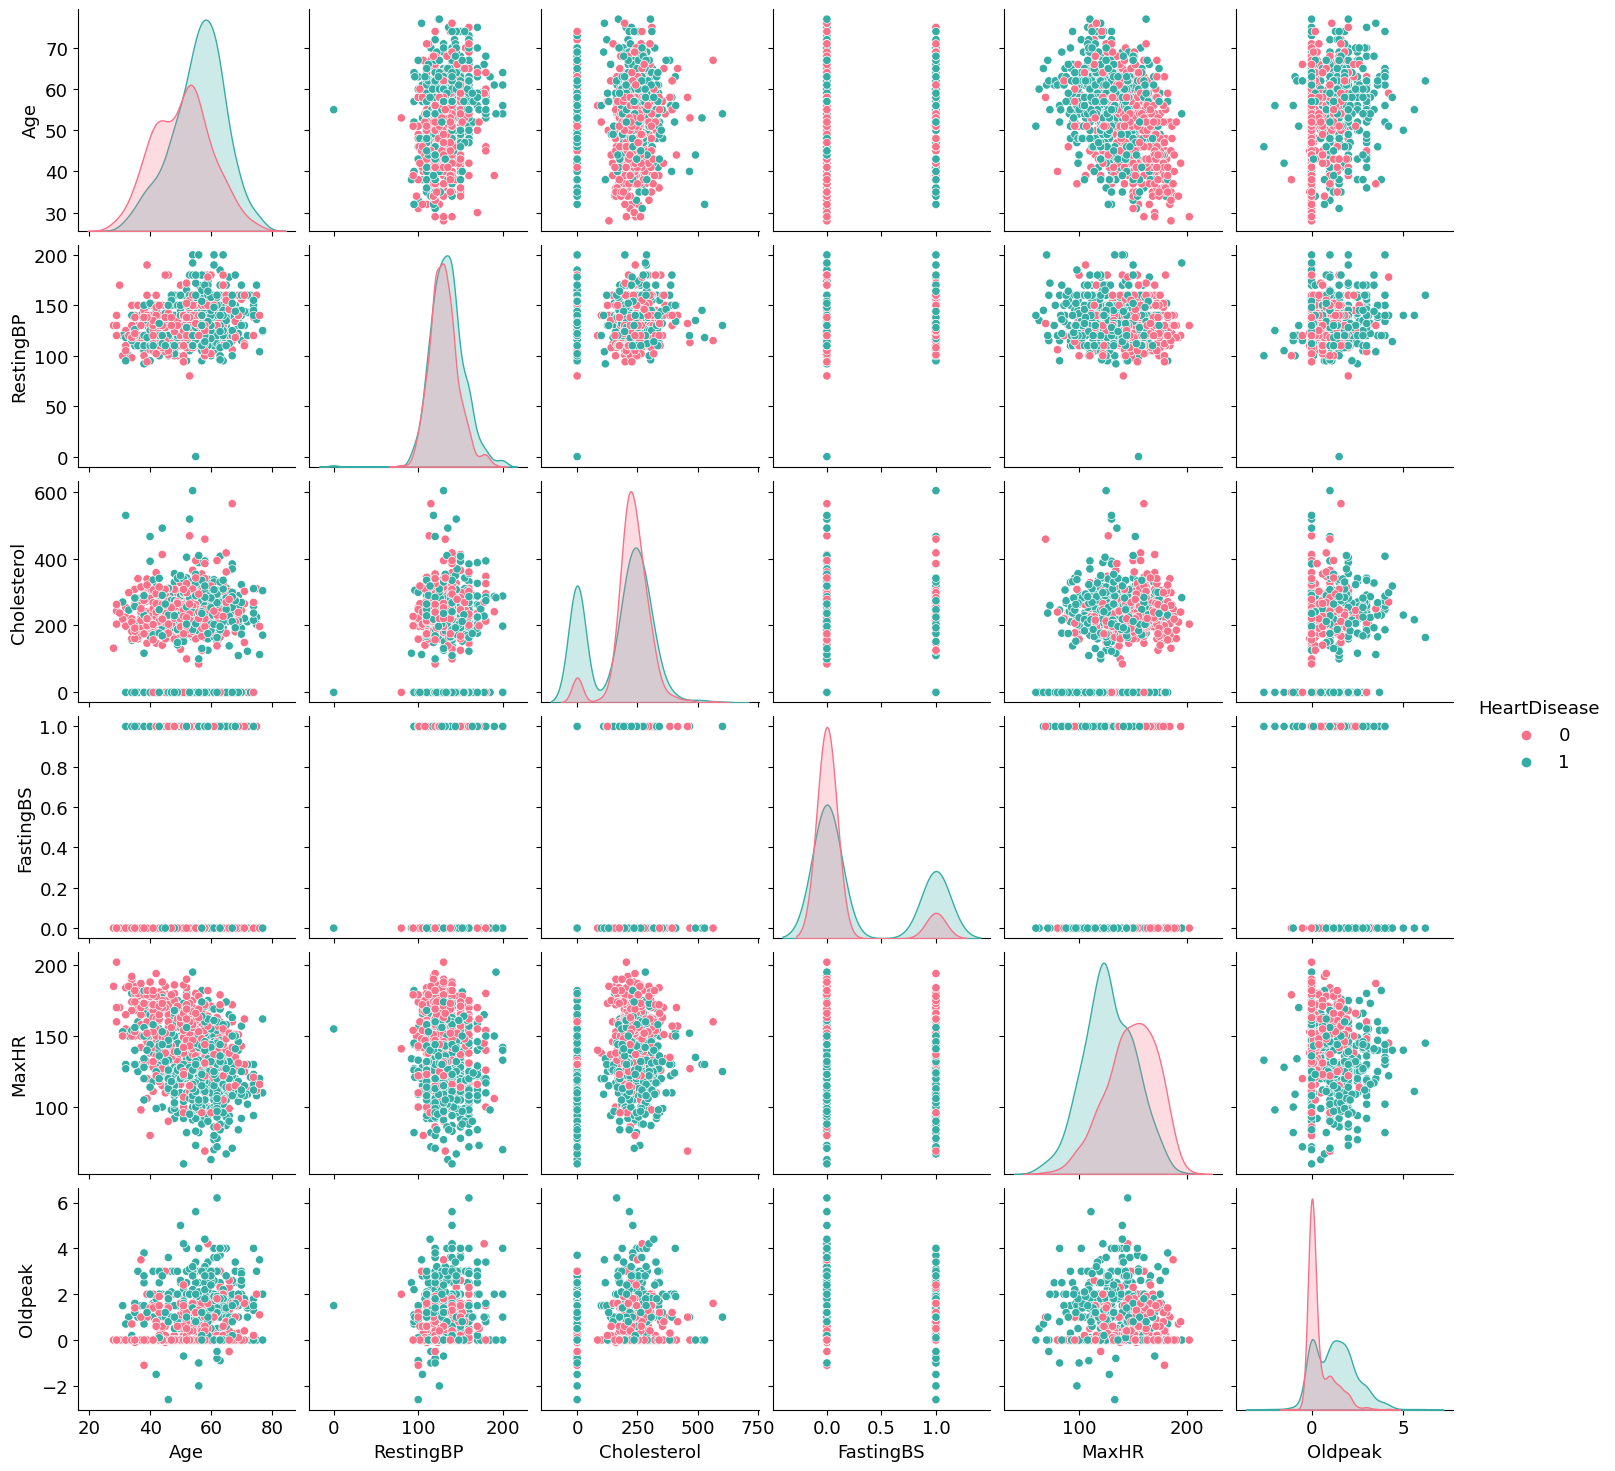

In [114]:
# Visualizing dataset using seaborn pairplot
sns.color_palette("flare", as_cmap=True)
sns.pairplot(df, hue='HeartDisease', palette='husl')
plt.show()

## Preprocessing the Data

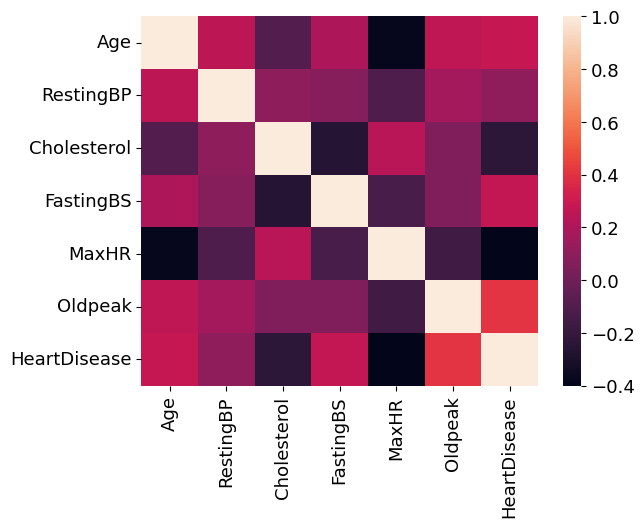

In [115]:
# Visualizing all features with numerical values using seaborn heatmap
sns.heatmap(df.corr())
plt.show()

In [116]:
# Creating a copy of our dataframe to manipulate non-numerical values
encoded_df = df.copy()

# Mapping values of the Sex and ExerciseAngina column to numbers
encoded_df.Sex = encoded_df.Sex.map({"M":1,"F":0})
encoded_df.ExerciseAngina = encoded_df.ExerciseAngina.map({"Y":1,"N":0})
encoded_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,ATA,140,289,0,Normal,172,0,0.0,Up,0
1,49,0,NAP,160,180,0,Normal,156,0,1.0,Flat,1
2,37,1,ATA,130,283,0,ST,98,0,0.0,Up,0
3,48,0,ASY,138,214,0,Normal,108,1,1.5,Flat,1
4,54,1,NAP,150,195,0,Normal,122,0,0.0,Up,0


In [117]:
# Creating a copy of the encoded dataframe and dropping the output class
feature_df = encoded_df.drop(['HeartDisease'],axis=1)

# Performing one-hot encoding on dataframe to columns with non-numerical values into categorical columns 
feature_df = pd.get_dummies(feature_df, drop_first=True)
feature_df.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ST_Slope_Flat,ST_Slope_Up
0,40,1,140,289,0,172,0,0.0,1,0,0,1,0,0,1
1,49,0,160,180,0,156,0,1.0,0,1,0,1,0,1,0
2,37,1,130,283,0,98,0,0.0,1,0,0,0,1,0,1
3,48,0,138,214,0,108,1,1.5,0,0,0,1,0,1,0
4,54,1,150,195,0,122,0,0.0,0,1,0,1,0,0,1


In [118]:
# Defining our x (ie. features) and y (ie. labels=output class)
x = feature_df.values
y = encoded_df.HeartDisease.values

In [119]:
# Using StandardScaler() to transform the training and testing datasets 
# This allows for the distribution to have a mean value 0 and standard deviation of 1
scaler = StandardScaler()

# Split data into a train set and a test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [120]:
# Initializing batch size
batch_size = 256

# Creating tensordataset for the train set
x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float().reshape(-1,1)
train_dataset = TensorDataset(x_train, y_train)

# Creating tensordataset for the test set
x_test = torch.tensor(x_test).float()
y_test = torch.tensor(y_test).float().reshape(-1,1)
test_dataset = TensorDataset(x_test, y_test)

# Defining train and test dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0])

print(f"Number of Training Samples = {len(train_dataloader.dataset)}\nNumber of Testing Samples = {len(test_dataloader.dataset)}")

Number of Training Samples = 734
Number of Testing Samples = 184


In [121]:
train_dataset.tensors[0].size()

torch.Size([734, 15])

## The Model

In [122]:
# Setting up the neural network
class HFModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Input layer
        self.input = nn.Linear(15,100)
        self.relu1 = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        
        # Hidden layer
        self.fc1 = nn.Linear(100,100)
        self.bnnorm1 = nn.BatchNorm1d(100)
        self.relu2 = nn.ReLU()
        
        # Output layer
        self.output = nn.Linear(100,1)
        self.dr = 0.2
    
    def forward(self,x):
        x = self.relu1(self.input(x))
        x = self.dropout(x)
        x = self.bnnorm1(x)
        x = self.relu2(self.fc1(x))
        x = self.dropout(x)
        
        return self.output(x)

## Training the Model

In [123]:
# Defining our train function
def train(model: HFModel, 
          train_dataset: Dataset,
          test_dataset: Dataset,
          epoch: int,
          lr: float,
          max_batches=None):
    
    # Initializing train and test accuracy to store values
    train_acc = torch.zeros(epoch)
    test_acc = torch.zeros(epoch)
    
    # Redefining train and test dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=max_batches, shuffle=True, drop_last=True)
    test_dataloader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0])
    
    # Calling loss function and optimizer
    lossFunc = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Training the model
    for i in range(epoch):
        start = time.time()
        for xs, targets in train_dataloader:
            # Finding train accuracy
            acc_list = []
            model.train()
            
            # Forward pass
            y_out = model(xs)
            loss = lossFunc(y_out, targets)
            y_out = (y_out>0).float()
            acc_list.append(100*torch.mean((y_out==targets).float()).item())
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Finding test accuracy
        train_acc[i] = np.mean(acc_list)
        model.eval()
        xs, targets = next(iter(test_dataloader))
        y_out = model(xs)
        loss = lossFunc(y_out, targets)
        y_out = (y_out>0).float()
        test_acc[i] = 100*torch.mean((targets==y_out).float()).item()
        
        duration = time.time() - start
        
        # Displaying epoch information
        print("[Epoch {} ({:.2f}s)]: "
              "Loss={:.2f}%, "
              "Train Accuracy={:.2f}%, "
              "Test Accuracy={:.2f}%"
              .format(i, 
                      duration, 
                      loss, 
                      train_acc[i], 
                      test_acc[i]
                     )
             )
        
    return model, test_acc, train_acc

In [129]:
# Running train model
model = HFModel()
model, test_acc, train_acc = train(model, train_dataset, test_dataset, epoch=50, lr=0.001, max_batches=256)

[Epoch 0 (0.03s)]: Loss=0.68%, Train Accuracy=46.09%, Test Accuracy=48.37%
[Epoch 1 (0.02s)]: Loss=0.65%, Train Accuracy=65.62%, Test Accuracy=67.93%
[Epoch 2 (0.01s)]: Loss=0.62%, Train Accuracy=75.78%, Test Accuracy=80.43%
[Epoch 3 (0.01s)]: Loss=0.58%, Train Accuracy=77.34%, Test Accuracy=83.15%
[Epoch 4 (0.01s)]: Loss=0.55%, Train Accuracy=88.67%, Test Accuracy=85.87%
[Epoch 5 (0.01s)]: Loss=0.51%, Train Accuracy=87.11%, Test Accuracy=85.87%
[Epoch 6 (0.01s)]: Loss=0.48%, Train Accuracy=83.20%, Test Accuracy=87.50%
[Epoch 7 (0.01s)]: Loss=0.45%, Train Accuracy=80.08%, Test Accuracy=86.96%
[Epoch 8 (0.01s)]: Loss=0.42%, Train Accuracy=85.16%, Test Accuracy=86.41%
[Epoch 9 (0.01s)]: Loss=0.39%, Train Accuracy=87.11%, Test Accuracy=86.41%
[Epoch 10 (0.01s)]: Loss=0.37%, Train Accuracy=85.94%, Test Accuracy=86.41%
[Epoch 11 (0.01s)]: Loss=0.35%, Train Accuracy=85.94%, Test Accuracy=86.41%
[Epoch 12 (0.01s)]: Loss=0.34%, Train Accuracy=85.94%, Test Accuracy=86.41%
[Epoch 13 (0.01s)]: Lo

## The Results

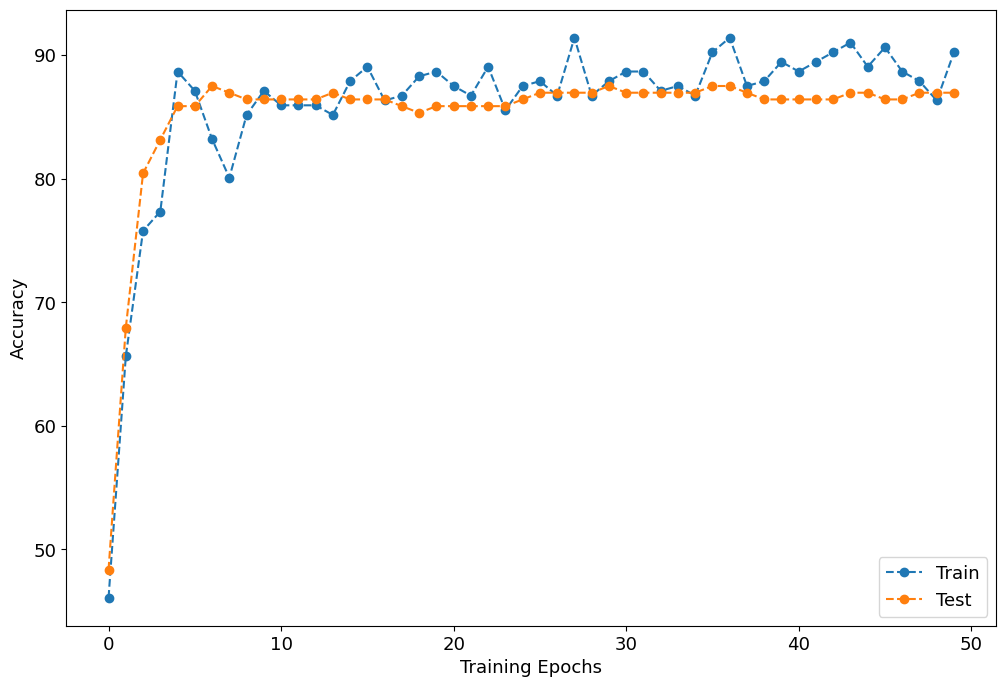

In [130]:
# Visualizing the train and test accuracy
model_fig = plt.figure(figsize=(12,8))
plt.plot(train_acc, 'o--', label='Train')
plt.plot(test_acc, 'o--', label='Test')
plt.xlabel('Training Epochs')
plt.ylabel('Accuracy')
plt.legend()
model_fig

In [126]:
# Predictions for testing set
x, y = next(iter(test_dataloader))
y_out = model(x)
test_pred = (y_out>0).float()

# Predictions for training set
train_pred = (model(train_dataloader.dataset.tensors[0])>1).float()

# Initializing metrics for confusion matrix
train_conf = confusion_matrix(train_dataloader.dataset.tensors[1], train_pred)
test_conf = confusion_matrix(y, test_pred)

In [127]:
# Calculating f1 score
f1_train = f1_score(train_dataloader.dataset.tensors[1], train_pred)
f1_test = f1_score(y, test_pred)

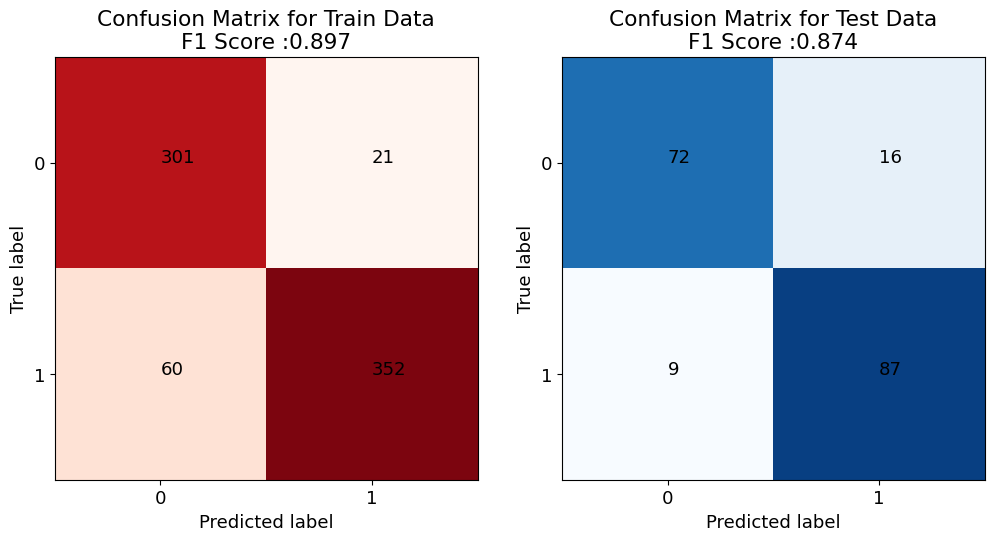

In [128]:
# Plotting the confusion matrix for train and test datasets
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

plt.rcParams.update({'font.size':13})

ax[0].set_title(f"Confusion Matrix for Train Data\nF1 Score :{f1_train:.3f}")
ax[0].imshow(train_conf, 'Reds', vmax=len(train_pred) / 2)
ax[0].set_xticks([0,1])
ax[0].set_yticks([0,1])
ax[0].set_xlabel("Predicted label")
ax[0].set_ylabel("True label")

ax[0].text(0, 0, train_conf[0, 0])
ax[0].text(0, 1, train_conf[1, 0])
ax[0].text(1, 0, train_conf[0, 1])
ax[0].text(1, 1, train_conf[1, 1])


ax[1].set_title(f"Confusion Matrix for Test Data\nF1 Score :{f1_test:.3f}")
ax[1].imshow(test_conf, 'Blues', vmax=len(test_pred) / 2)
ax[1].set_xticks([0, 1])
ax[1].set_yticks([0, 1])
ax[1].set_xlabel("Predicted label")
ax[1].set_ylabel("True label")

ax[1].text(0, 0, test_conf[0, 0])
ax[1].text(0, 1, test_conf[1, 0])
ax[1].text(1, 0, test_conf[0, 1])
ax[1].text(1, 1, test_conf[1, 1])
fig

## Final Remarks

## Dataset Citation & Acknowledgement
fedesoriano. (September 2021). Heart Failure Prediction Dataset. Retrieved [Apr 16, 2023] from https://www.kaggle.com/fedesoriano/heart-failure-prediction.  